In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-drop-out-prediction/train.csv
/kaggle/input/students-drop-out-prediction/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/students-drop-out-prediction/train.csv')
test = pd.read_csv('/kaggle/input/students-drop-out-prediction/test.csv')
# train.head, test.head

In [3]:
train.shape, test.shape

((3796, 43), (1628, 42))

### Preprocessing

In [4]:
numeric = {'v_16': 'Ratio',
'v_2': 'Ratio',
'v_8': 'Ratio',
'v_7': 'Ratio', 'v_34': 'Ratio', 'v_35': 'Ratio', 'v_36': 'Ratio', 'v_37': 'Ratio', 
'v_38': 'Ratio', 'v_39': 'Ratio','v_40': 'Ratio'}
nominal = {'v_32': 'Nominal', 'v_4': 'Nominal',
'v_3': 'Nominal',
'v_20': 'Nominal',
'v_21': 'Nominal',
'v_18': 'Nominal',
'v_25': 'Nominal',
'v_12': 'Nominal',}
ordinal = {'v_15': 'Ordinal',
'v_19': 'Ordinal',
'v_13': 'Ordinal',
'v_33': 'Ordinal',
'v_17': 'Ordinal',
'v_29': 'Ordinal',
'v_23': 'Ordinal',
'v_6': 'Ordinal', 'v_24': 'Ordinal', 'v_10': 'Ordinal', 'v_5': 'Ordinal',
'v_22': 'Ordinal', 'v_0': 'Ordinal'}

print(type(numeric.keys()),nominal.keys(),ordinal.keys())

<class 'dict_keys'> dict_keys(['v_32', 'v_4', 'v_3', 'v_20', 'v_21', 'v_18', 'v_25', 'v_12']) dict_keys(['v_15', 'v_19', 'v_13', 'v_33', 'v_17', 'v_29', 'v_23', 'v_6', 'v_24', 'v_10', 'v_5', 'v_22', 'v_0'])


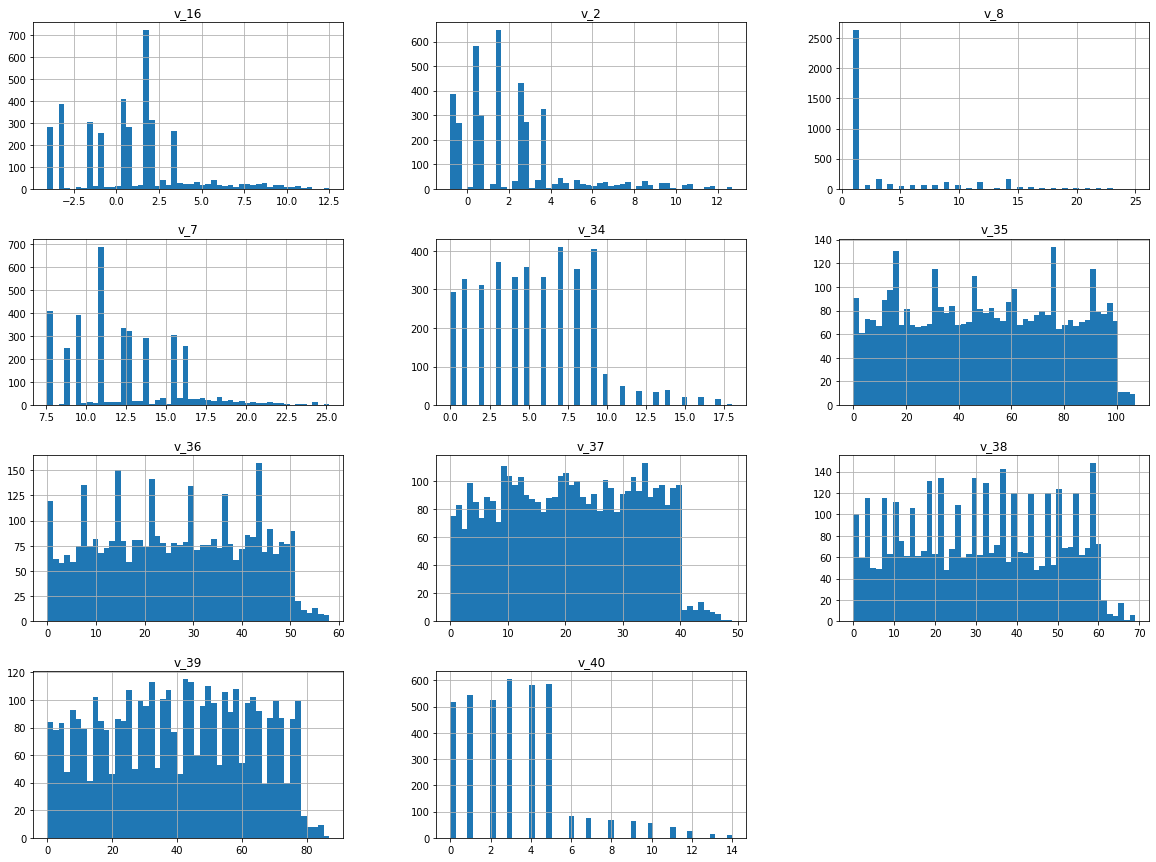

In [5]:
train[list(numeric.keys())].hist(bins=50, figsize=(20,15))
plt.show()

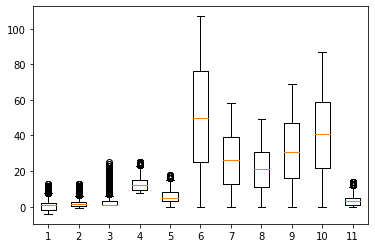

In [6]:
plt.boxplot(train[list(numeric.keys())])
plt.show()

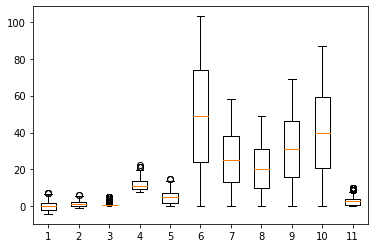

In [7]:
def remove_outlier(df_in, col_names):
    df_out=df_in
    for col_name in col_names:
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_out.loc[(df_out[col_name] > fence_low) & (df_out[col_name] < fence_high)]
    return df_out
otrain=remove_outlier(train, list(numeric.keys()))
plt.boxplot(otrain[list(numeric.keys())])
plt.show()

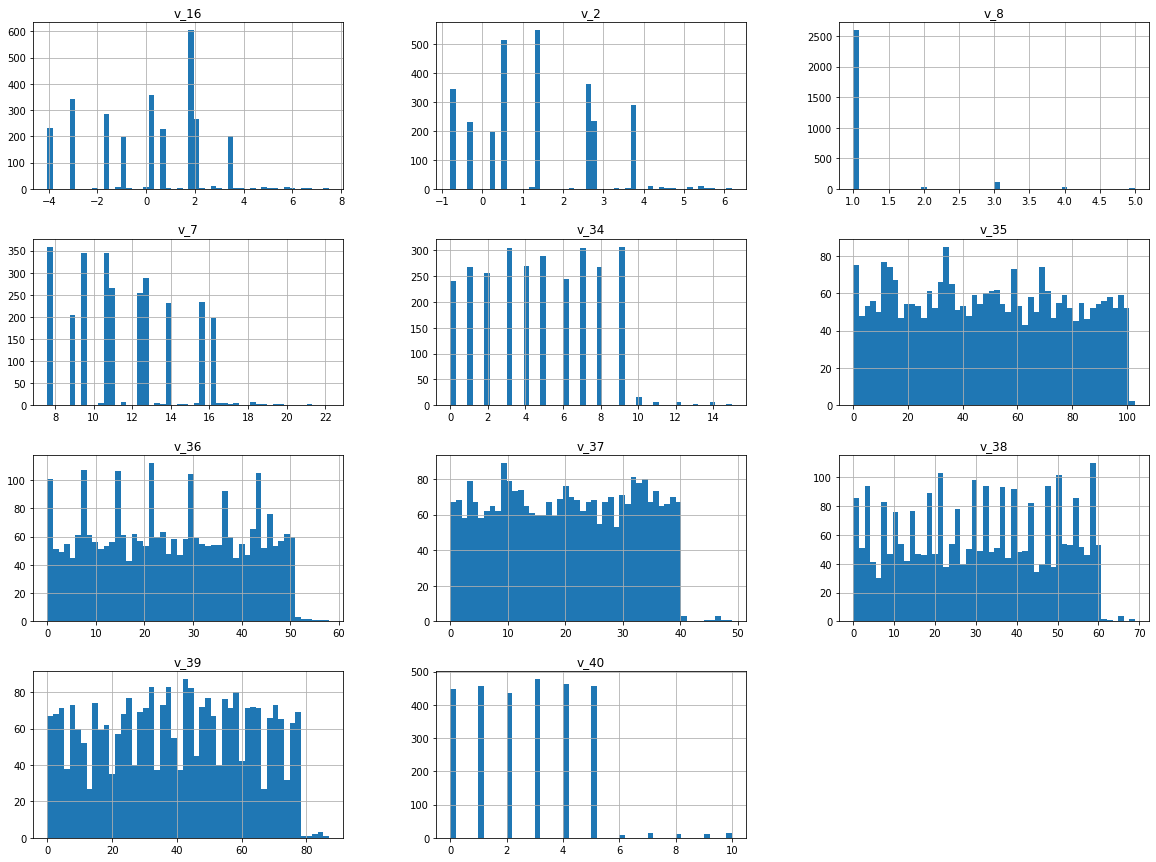

In [8]:
otrain[list(numeric.keys())].hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
otrain.shape, train.shape

((2792, 43), (3796, 43))

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('std_scalar', StandardScaler())])

In [11]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelBinarizer

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# onehot encode
ohe = OneHotEncoder(sparse=False,handle_unknown="ignore")

#Binary encode
# lb = MyLabelBinarizer()
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('num', num_pipeline, list(numeric.keys())),
                        ('ohe', ohe, list(nominal.keys())),
                        ('oe', oe,list(ordinal.keys()))], remainder='passthrough')



In [12]:
label = otrain['label']
features = otrain.drop(['label'], axis=1)
features.shape, label.shape

((2792, 42), (2792,))

In [13]:
ft = ct.fit_transform(features)
feature_trans = pd.DataFrame(ft)
feature_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,445,446,447,448,449,450,451,452,453,454
0,0.308032,-1.102017,-0.257366,0.841590,-1.255461,1.501749,1.455477,-1.606893,0.966415,-0.606449,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,26.0,0.0
1,2.759015,2.746301,4.744259,1.208803,0.429916,-0.701354,0.781285,0.400877,1.247791,-0.205078,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,27.0,0.0
2,0.835079,-0.494388,-0.257366,-0.186605,-1.255461,-1.424247,0.579028,-1.355922,0.685039,-0.071288,...,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,31.0,0.0
3,0.835079,-0.494388,-0.257366,-0.186605,0.766991,-0.425966,0.983543,0.568191,0.685039,1.132824,...,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,26.0,0.0
4,-1.367378,-1.439589,-0.257366,-0.810867,0.766991,-0.735777,0.039674,-0.352037,-0.496742,0.865244,...,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,26.0,0.0


### Checking for Missing Values

In [14]:
train.isna().sum().sum()

0

### Balancing Sample

In [15]:
# samplers =[]
# from imblearn.under_sampling import RandomUnderSampler
# samplers.append(RandomUnderSampler(random_state=0))
# from imblearn.over_sampling import RandomOverSampler
# samplers.append(RandomOverSampler(random_state=0))
# from imblearn.over_sampling import SMOTE
# samplers.append(SMOTE(random_state=0))
# from imblearn.over_sampling import ADASYN 
# samplers.append(ADASYN(random_state=0))

# test_models=[]
# from sklearn.linear_model import LogisticRegression
# test_models.append(LogisticRegression(random_state=0))
# from sklearn.svm import SVC
# test_models.append(SVC(C= 1000, gamma= 0.0001, kernel= 'rbf',random_state=0))
# from sklearn.naive_bayes import GaussianNB
# test_models.append(GaussianNB())
# from sklearn.neighbors import KNeighborsClassifier
# test_models.append(KNeighborsClassifier())
# from sklearn.tree import DecisionTreeClassifier
# test_models.append(DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=100, max_features='auto'))
# from sklearn.ensemble import BaggingClassifier
# cart = DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=100, max_features='auto')
# test_models.append(BaggingClassifier(base_estimator=cart,n_estimators=10, random_state=0))
# from sklearn.ensemble import GradientBoostingClassifier
# test_models.append(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=100, random_state=0))
# from sklearn.ensemble import RandomForestClassifier
# test_models.append(RandomForestClassifier(random_state=0, n_estimators=100, max_features=10))
# from xgboost import XGBClassifier
# test_models.append(XGBClassifier())

# f1scores = []
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# for j in test_models:
#     entry=[]
#     for i in samplers:
#         X, y = i.fit_resample(feature_trans, label)
#         xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
#         test_model = j.fit(xtrain, ytrain)
#         yhattm=test_model.predict(xtest)
#         f1scores.append([j, i,f1_score(ytest, yhattm, average='micro')])


In [16]:
# pd.DataFrame(f1scores)

In [17]:
feature_trans = train.drop(['label'], axis=1)
label = train['label']

In [18]:
from imblearn.over_sampling import ADASYN
ros = ADASYN()
X_res, y_res = ros.fit_resample(feature_trans, label)

## Train test split

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.2, shuffle=True, random_state=0)
xtrain.shape

(4441, 42)

## Model
### Baseline Model

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

blmodel = GaussianNB()
# blmodel.fit(xtrain, ytrain)

In [21]:
scores = cross_val_score(blmodel, xtrain, ytrain, scoring='f1_micro', cv=10)
scores

array([0.5011236 , 0.56081081, 0.52477477, 0.51126126, 0.52927928,
       0.49099099, 0.56981982, 0.47297297, 0.57207207, 0.5       ])

### Logistic

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
# log = LogisticRegression(random_state=0)
# lg = GridSearchCV(log,grid,cv=10).fit(xtrain, ytrain)
# lg.score(xtest,ytest)


In [23]:
# lg.best_params_

In [24]:
logr = LogisticRegression(C= 100, penalty= 'l2')
logr = logr.fit(xtrain, ytrain)
yhat=logr.predict(xtest)
from sklearn.metrics import f1_score
f1_score(ytest, yhat, average='micro')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5598559855985599

In [25]:
# from sklearn.neighbors import KNeighborsClassifier
# grid = {"n_neighbors":range(1,50)}
# neigh = KNeighborsClassifier()
# nn = GridSearchCV(neigh,grid,cv=10).fit(xtrain, ytrain)

# yhatnn=nn.predict(xtest)
# f1_score(ytest, yhatnn, average='micro')

In [26]:
# nn.best_params_

In [27]:
# from sklearn.svm import SVC
# grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
# sv = SVC(random_state=0)
# svc = GridSearchCV(sv, grid).fit(xtrain, ytrain)

# yhatsvc = svc.predict(xtest)
# f1_score(ytest, yhatsvc, average='micro')

In [28]:
# svc.best_params_

In [29]:
from sklearn.svm import SVC
svcbp = SVC(C= 1000, gamma= 0.0001, kernel= 'rbf',random_state=0)
svcbp = svcbp.fit(xtrain, ytrain)
yhatsvc=svcbp.predict(xtest)
from sklearn.metrics import f1_score
f1_score(ytest, yhatsvc, average='micro')

0.7425742574257425

In [30]:
# from sklearn.tree import DecisionTreeClassifier
# cart = DecisionTreeClassifier(criterion='gini')
# grid = {'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth' : [10,100,1000],
#         'min_samples_split' : [1,10, 100],
        
#              }
# cartsearch = GridSearchCV(cart, grid, cv=5).fit(xtrain, ytrain)
# cartsearch.score(xtest,ytest)

In [31]:
# cartsearch.best_params_

In [32]:
from sklearn.tree import DecisionTreeClassifier
cart = DecisionTreeClassifier(random_state=0, criterion='gini',max_depth=100, max_features='auto')
cart.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=100, max_features='auto', random_state=0)

In [33]:
yhatcart=cart.predict(xtest)
f1_score(ytest, yhatcart, average='micro')

0.63996399639964

In [34]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(base_estimator=cart,n_estimators=10, random_state=0).fit(xtrain, ytrain)
yhatbag=bag.predict(xtest)
f1_score(ytest, yhatbag, average='micro')

0.7353735373537353

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=100, random_state=0).fit(xtrain, ytrain)
yhatboost=boost.predict(xtest)
f1_score(ytest, yhatboost, average='micro')

0.7092709270927092

In [36]:
from sklearn.ensemble import RandomForestClassifier
freg = RandomForestClassifier(random_state=0)

# treescores = cross_val_score(freg, feature_trans, label, scoring="f1_micro", cv=10)
# treescores

In [37]:
# treescores2 = cross_val_score(freg, xtrain, ytrain, scoring="f1_micro", cv=10)
# treescores2

In [38]:
# param_grid = [{'n_estimators':[10,100], 'max_features':[10,50,100,200,300,400,500,600,650,672]}]
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(freg, param_grid, cv=5, scoring='f1_micro', return_train_score=True)
# grid_search.fit(X_res, y_res)

In [39]:
# grid_search.best_params_, grid_search.best_estimator_

In [40]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(xtrain, ytrain)
yhatxb=xgbc.predict(xtest)
f1_score(ytest, yhatxb, average='micro')

0.8262826282628263

In [41]:
# from sklearn.model_selection import cross_val_score
# xgbc_cv = cross_val_score(xgbc, feature_trans, label, scoring="f1_micro", cv=10)
# xgbc_cv

In [42]:
from sklearn.ensemble import RandomForestClassifier
freg = RandomForestClassifier(random_state=0, n_estimators=100, max_features=10)

In [43]:
f1_score(ytest, freg.fit(xtrain, ytrain).predict(xtest), average='micro')

0.784878487848785

In [44]:
xgbc.fit(feature_trans, label)
test_trans = ct.transform(test)
test_trans= pd.read_csv('/kaggle/input/students-drop-out-prediction/test.csv')
sub = xgbc.predict(test_trans)
subd = pd.DataFrame( sub, columns=['label'])
subd['id']=subd.index
subd

,label,id
0,1,0
1,1,1
2,2,2
3,1,3
4,1,4
...,...,...
1623,0,1623
1624,1,1624
1625,0,1625
1626,2,1626


In [45]:
submis= pd.DataFrame( subd, columns=['id', 'label'])
submis.to_csv('submission.csv', index=False)
su = pd.read_csv('submission.csv')
su.head()

,id,label
0,0,1
1,1,1
2,2,2
3,3,1
4,4,1
